# **Experiment 7: Clustering Human Activity Recognition Data using K-Means, DBSCAN, and Hierarchical Clustering**

In [104]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [46]:
# LOADING THE DATASET
X_train = pd.read_csv('/content/drive/MyDrive/ml-lab/ass7/train/X_train.txt', sep="\\s+", header=None)
y_train = pd.read_csv('/content/drive/MyDrive/ml-lab/ass7/train/y_train.txt', sep="\\s+", header=None)
subjects = pd.read_csv('/content/drive/MyDrive/ml-lab/ass7/train/subject_train.txt', sep="\\s+", header=None)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("subjects shape:", subjects.shape)

X_train shape: (7352, 561)
y_train shape: (7352, 1)
subjects shape: (7352, 1)


In [47]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [48]:
# STANDARDIZATION
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

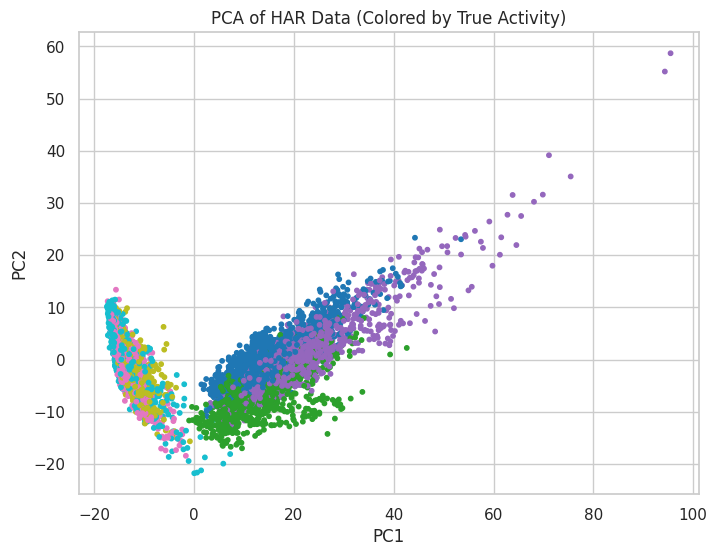

In [49]:
# DIMENSIONALITY REDUCTION (for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train[0], cmap='tab10', s=10)
plt.title('PCA of HAR Data (Colored by True Activity)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

**K-Means Clustering + Elbow/Sillhouette**

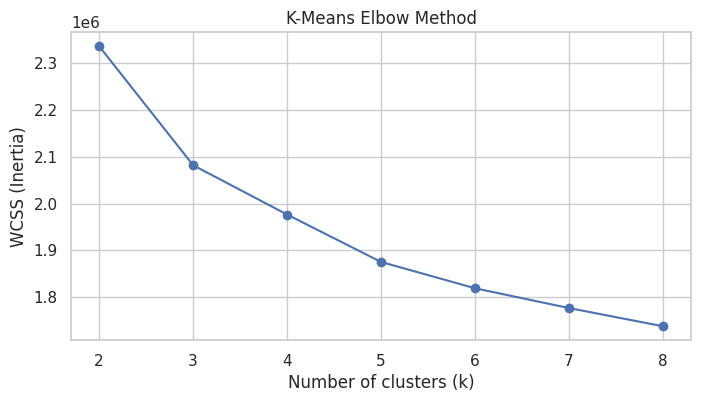

In [64]:
wcss = []
sil_scores = []
K_range = range(2,9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow curve
plt.figure(figsize=(8,4))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('K-Means Elbow Method')
plt.show()

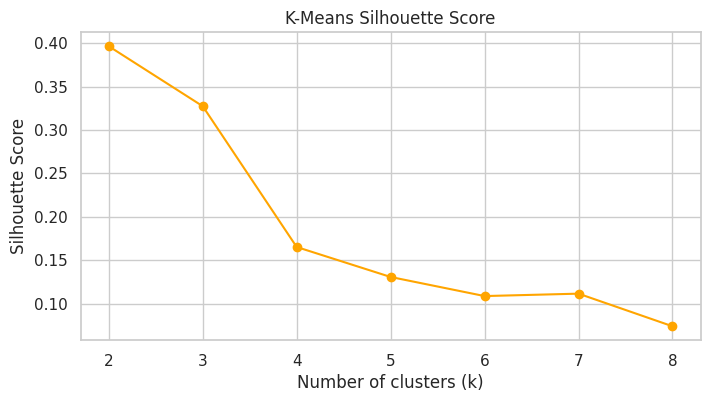

In [65]:
# Silhouette curve
plt.figure(figsize=(8,4))
plt.plot(K_range, sil_scores, marker='o', color='orange')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means Silhouette Score')
plt.show()

In [68]:
table = pd.DataFrame({
        "k": list(K_range),
        "WCSS": wcss,
        "Silhouette": sil_scores
    })
print(table.to_string(index=False))

 k         WCSS  Silhouette
 2 2.336224e+06    0.396505
 3 2.081850e+06    0.327408
 4 1.976453e+06    0.165163
 5 1.875066e+06    0.130639
 6 1.818790e+06    0.108641
 7 1.776519e+06    0.111424
 8 1.737555e+06    0.073861


In [80]:
# choosing best k
k_best = 3
kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_scaled)

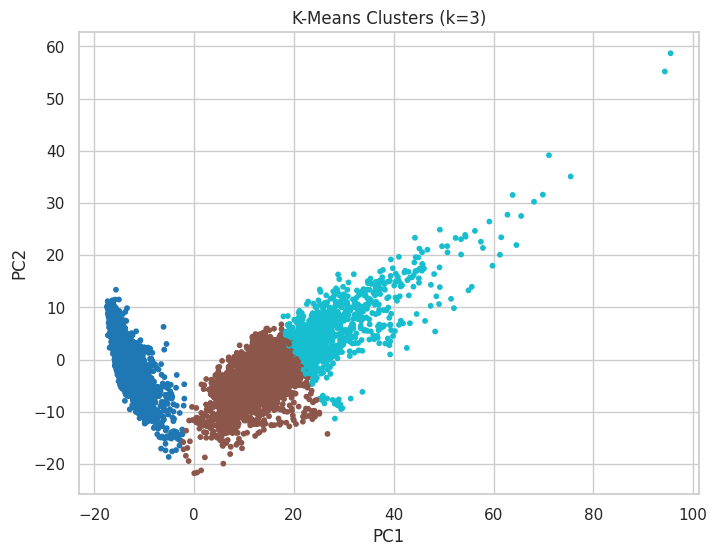

In [81]:
# PCA visualization of clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=k_labels, cmap='tab10', s=10)
plt.title(f'K-Means Clusters (k={k_best})')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

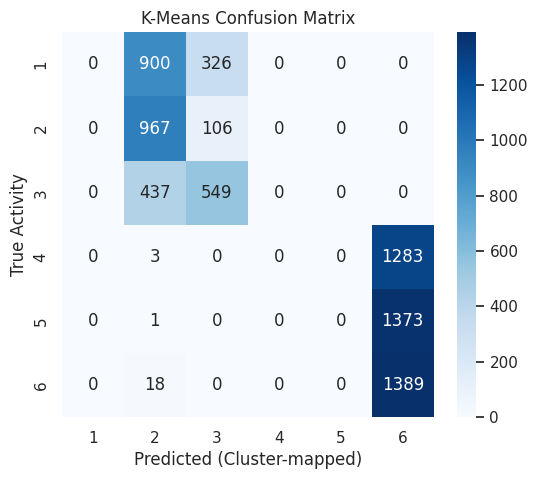

In [105]:
def cluster_confusion_matrix(true_labels, cluster_labels, algo_name="K-Means"):
    # Map clusters to most common true label
    labels = np.unique(cluster_labels)
    mapping = {}
    for lbl in labels:
        mask = cluster_labels == lbl
        true_for_cluster = true_labels[mask]
        if len(true_for_cluster) == 0:
            continue
        # majority vote
        mapping[lbl] = np.bincount(true_for_cluster).argmax()

    # Convert cluster labels to mapped labels
    mapped_labels = np.array([mapping[lbl] for lbl in cluster_labels])

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, mapped_labels)
    cm_df = pd.DataFrame(cm, index=np.unique(true_labels), columns=np.unique(true_labels))

    # Plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{algo_name} Confusion Matrix")
    plt.xlabel("Predicted (Cluster-mapped)")
    plt.ylabel("True Activity")
    plt.show()

    return cm_df

# Example usage
cm_kmeans = cluster_confusion_matrix(y_train[0].values, k_labels, "K-Means")

**DBScan**

In [88]:
def tune_dbscan(X, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    results = []

    for eps in eps_values:
        for min_s in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_s).fit(X)
            labels = db.labels_

            # skip if DBSCAN assigns all points to noise or 1 cluster
            if len(set(labels)) <= 1:
                continue

            try:
                sil = silhouette_score(X, labels)
                dbi = davies_bouldin_score(X, labels)
                ch = calinski_harabasz_score(X, labels)
            except:
                continue

            results.append((eps, min_s, sil, dbi, ch))

            if sil > best_score:
                best_score = sil
                best_params = (eps, min_s)

    return best_params, results

# Example usage
eps_range = np.linspace(10, 15, 20, 25)
min_samples_range = [5, 10, 15, 20]

best_params, results = tune_dbscan(X_scaled, eps_range, min_samples_range)

if best_params is None:
    print("DBSCAN couldn't form valid clusters in the tested range.")
else:
    print("Best params:", best_params)


Best params: (np.float64(15.0), 20)


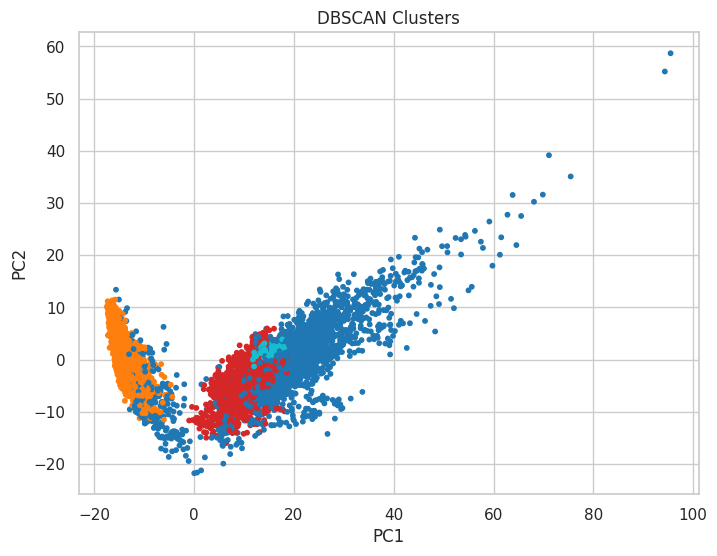

In [91]:
dbscan = DBSCAN(eps=14, min_samples=20)
db_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap='tab10', s=10)
plt.title('DBSCAN Clusters')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

**Hierarchical Clustering**

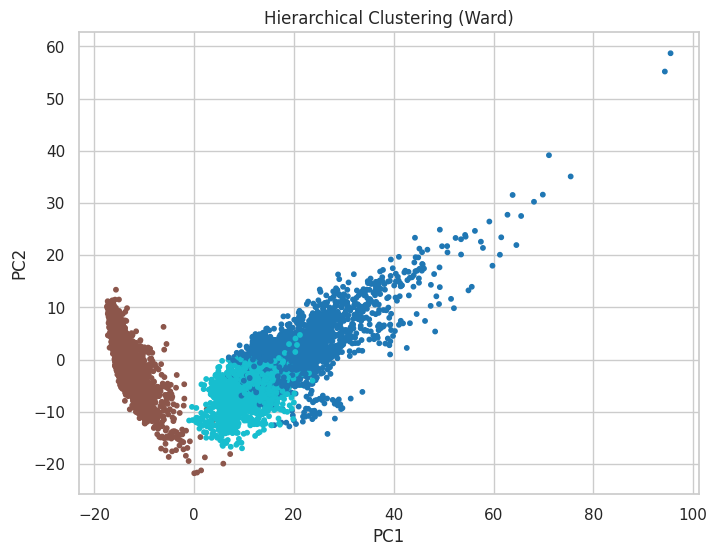

In [83]:
agg = AgglomerativeClustering(n_clusters=k_best, linkage='ward')
agg_labels = agg.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=agg_labels, cmap='tab10', s=10)
plt.title('Hierarchical Clustering (Ward)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

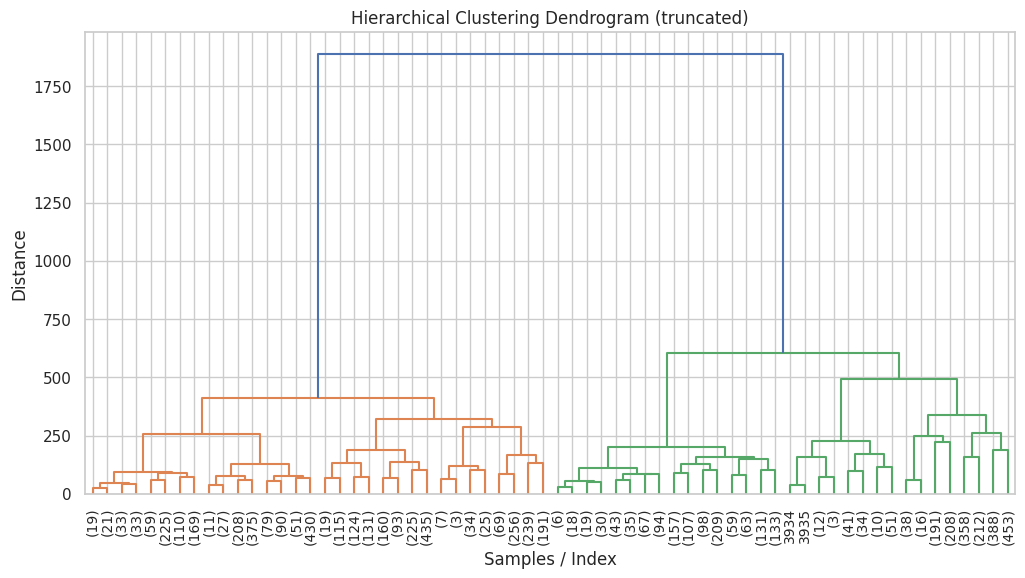

In [93]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Using Ward linkage (same as your Agglomerative clustering)
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12,6))
dendrogram(Z, truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Samples / Index")
plt.ylabel("Distance")
plt.show()

In [92]:
# EVALUATION METRICES
def clustering_metrics(X, cluster_labels, true_labels=None, algo_name="Algorithm"):
    metrics = {}
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # exclude noise for DBSCAN

    # Internal metrics (if at least 2 clusters)
    if n_clusters > 1:
        metrics['Silhouette'] = silhouette_score(X, cluster_labels)
        metrics['Davies-Bouldin'] = davies_bouldin_score(X, cluster_labels)
        metrics['Calinski-Harabasz'] = calinski_harabasz_score(X, cluster_labels)
    else:
        metrics['Silhouette'] = None
        metrics['Davies-Bouldin'] = None
        metrics['Calinski-Harabasz'] = None

    # External metrics (if true labels provided)
    if true_labels is not None:
        metrics['ARI'] = adjusted_rand_score(true_labels, cluster_labels)
        metrics['NMI'] = normalized_mutual_info_score(true_labels, cluster_labels)

    return pd.DataFrame({algo_name: metrics}).T

y_true = y_train[0]  # ground truth
k_metrics = clustering_metrics(X_scaled, k_labels, y_true, "K-Means")
db_metrics = clustering_metrics(X_scaled, db_labels, y_true, "DBSCAN")
agg_metrics = clustering_metrics(X_scaled, agg_labels, y_true, "Hierarchical")

all_metrics = pd.concat([k_metrics, db_metrics, agg_metrics])
all_metrics


,Silhouette,Davies-Bouldin,Calinski-Harabasz,ARI,NMI
K-Means,0.327408,1.745773,3605.263229,0.327923,0.516310
DBSCAN,0.141134,2.859937,825.391505,0.275990,0.426156
Hierarchical,0.254790,1.927494,3350.021309,0.342153,0.539664


In [99]:
internal_metrics = all_metrics[['Silhouette','Davies-Bouldin','Calinski-Harabasz']]
external_metrics = all_metrics[['ARI','NMI']]

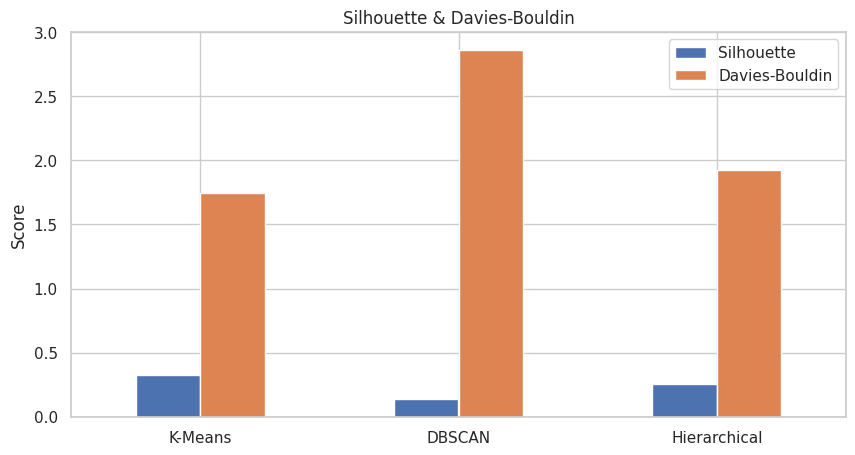

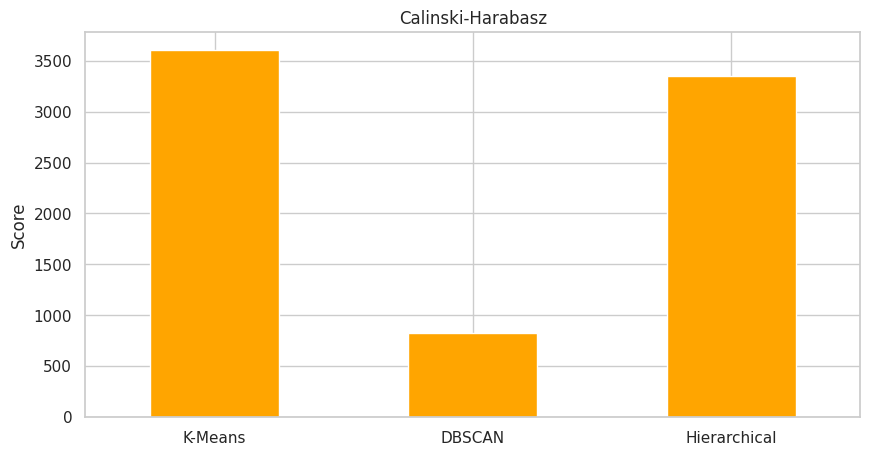

In [102]:
# Plot Silhouette + Davies-Bouldin
internal_metrics[['Silhouette','Davies-Bouldin']].plot(kind='bar', figsize=(10,5))
plt.title('Silhouette & Davies-Bouldin')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Plot Calinski-Harabasz separately
internal_metrics['Calinski-Harabasz'].plot(kind='bar', figsize=(10,5), color='orange')
plt.title('Calinski-Harabasz')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


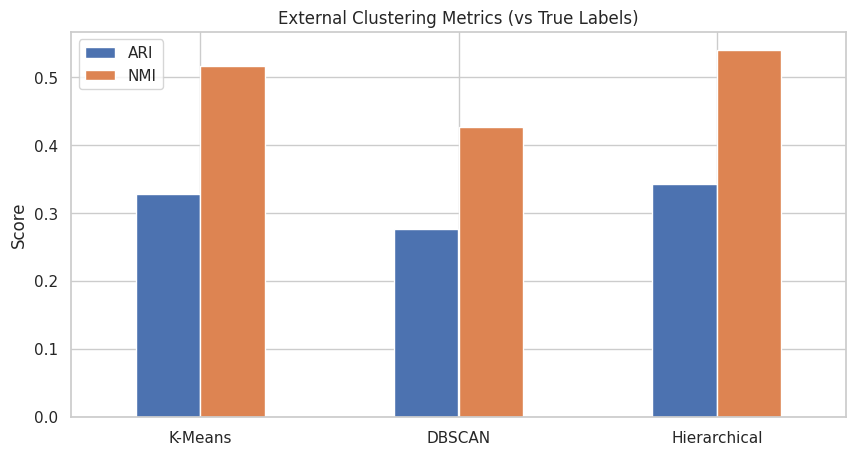

In [98]:
# External
external_metrics.plot(kind='bar', figsize=(10,5))
plt.title('External Clustering Metrics (vs True Labels)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()